# Test 5 and Test 8 (Binary Classification on Lenses)

## Import required libraries

In [1]:
# Import required libraries
import torch
import torchvision
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from albumentations.pytorch import ToTensorV2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import glob
import timm
import uuid
import tqdm
from PIL import Image
import cv2

## Setup Wandb to log the experiment and models

In [3]:
wandb.login()

wandb: Currently logged in as: lawjarp. Use `wandb login --relogin` to force relogin


True

## Setup Configuration

* We will be using a image size of 224,224
* Swin transformers are seen to perform very well in image classification tasks and have been used regualry for the same purpose. (Competitions in Kaggle)

In [4]:
config = {
    "image_size": (224,224),
    "batch_size": 16,
    "base_model": "swin_s3_tiny_224"
}

## Get Data files

In [5]:
# Get data
# Split data into train and test
categories = {
    "sub": 0,
    "no_sub": 1,
}

dataset_path = "/notebooks/gsoc-prep-23/ml4sci/data/lenses/"

# Get file paths as a list
all_files = glob.glob(dataset_path + "*/*")
all_labels = [x.split('/')[-2] for x in all_files]

print("Got files", len(all_files))

Got files 10000


In [6]:
print(all_files[0], all_labels[0])
print(all_files[-1], all_labels[-1])

/notebooks/gsoc-prep-23/ml4sci/data/lenses/sub/image_135943293325140772155714425003138958756.jpg sub
/notebooks/gsoc-prep-23/ml4sci/data/lenses/no_sub/image_30922263493132764425775209234469258991.jpg no_sub


(150, 150)


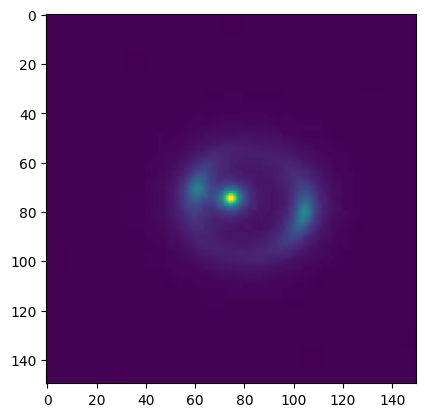

In [7]:
test = Image.open(all_files[0])
print(test.size)
plt.imshow(test)

## Define Dataset objects, augment and split data

In [49]:
# Dataset object
# Use albumentations for data augmentation
class SubstructureBinaryDataset(torch.utils.data.Dataset):
    def __init__(self, data_files, transform=None):
        self.data_files = data_files
        self.transform = transform
    def __len__(self):
        return len(self.data_files)
    def __getitem__(self, idx):
        # Open as one channel
        image = np.array((Image.open(self.data_files[idx])).convert('L'))
        # Get label from path
        label = categories[self.data_files[idx].split("/")[-2]]
        # Apply transformations
        if self.transform:
            image = self.transform(image=image)["image"]
        # Convert to tensor
        label = torch.tensor([label], dtype=torch.float32)
        # Min max normalise
        image = (image - image.min() ) / ( image.max() - image.min())
        return image.to(torch.float32),label

In [50]:
# Split into 90-10
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(all_files, test_size=0.1, random_state=42, stratify=all_labels)

In [51]:
# Define the augmentations
# Handles overfitting and facilitates better training
train_transform = A.Compose([
    A.Resize(*config['image_size']),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.pytorch.transforms.ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(*config['image_size']),
    A.pytorch.transforms.ToTensorV2()
])

train_dataset = SubstructureBinaryDataset(train_files, transform=train_transform)
val_dataset = SubstructureBinaryDataset(val_files, transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=8)

In [52]:
# Sanity check
b = next(iter(train_dataloader))
print(b[0][0].shape)
print(b[1][0].shape)

torch.Size([1, 224, 224])
torch.Size([1])


## Define Model
* Use a custom head
    * Add a few more layers with batchnorma and dropout

In [44]:
# Define pytorch model
# Use timm for pretrained models
# Define the pytorch model
# Create a model using timm
def create_model(model_name,num_classes=1):
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes, in_chans=1)
    # Check if classifier is parameter of the model
    if hasattr(model, 'head'):
        model.head = torch.nn.Sequential(
            torch.nn.Linear(model.head.in_features, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024,512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, num_classes),
            torch.nn.Sigmoid(),
        )
    return model

## Define Pytorch Lightning Module
* Define training steps
* Define validation steps
* Define the optimizers
* Define A Learning Scheduler
    * Used to control the rate of lr
    * Stabilises training and prevents overshooting 

In [45]:
# Define pl module
class SubstructureModel(pl.LightningModule):
    def __init__(self, num_classes, lr=1e-3):
        super().__init__()
        self.model = create_model(config['base_model'], num_classes=num_classes)
        self.criterion = torch.nn.BCELoss()
        self.lr = lr
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

In [46]:
# Train model
model = SubstructureModel(1)

## Setup Trainer object and logging 
* Use Modelcheckpoint to save best model; minimum `val_loss`
* Log the model weights to wandb

In [47]:
run_id = "ml4sci:t5:"+config['base_model']+":"+str(uuid.uuid4().hex)[:3]

# wandb_logger = WandbLogger(
#     project="gsoc-ml4sci",
#     entity="lawjarp",
#     name=run_id,
#     group=config['base_model'],
#     log_model=True,
# )
# Initialize a trainer
trainer = pl.Trainer(
    max_epochs=10,
    callbacks=[
        RichProgressBar(leave=True),
        ModelCheckpoint(dirpath='./models/', filename=run_id, monitor="val_loss", mode="min")
    ],
    # logger=wandb_logger
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Fit the model

In [48]:
trainer.fit(model, train_dataloader, val_dataloader)

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /notebooks/gsoc-prep-23/ml4sci/notebooks/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type            ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model     │ SwinTransformer │ 28.9 M │
│ 1 │ criterion │ BCELoss         │      0 │
└───┴───────────┴─────────────────┴────────┘

Trainable params: 28.9 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 28.9 M                                                                                               
Total estimated model params size (MB): 115

Output()

ValueError: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.

## Get AUC scores

In [17]:
model.to('cuda')
model.eval()
model_outputs = []
true_labels = []
with torch.no_grad():
    for inputs, labels in val_dataloader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)
        model_outputs.extend(outputs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve

def compute_auc_roc(model_outputs, true_labels):
    fpr, tpr, _ = roc_curve(true_labels, model_outputs)
    roc_auc = roc_auc_score(true_labels, model_outputs)
    return roc_auc, fpr, tpr

auc, fpr, tpr = compute_auc_roc(model_outputs, true_labels)

In [19]:
print("AUC scores", auc)

AUC scores 0.5


In [20]:
wandb.finish()

epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,▇▇▇▅▁▆▅▆▆█▆▆▇▆▅▆▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_loss,██▁▁▁▁
epoch,6
train_loss,0.6937
trainer/global_step,3599
val_loss,0.69315


## MISC

In [21]:
from fastai.vision.all import *

In [22]:
dls = DataLoaders(train_dataloader, val_dataloader)

In [23]:
model = create_model(config['base_model'], 1)

In [24]:
model

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate=none)
            (drop1): 

In [25]:
learn = Learner(dls, model, loss_func=BCELossFlat(), metrics=accuracy)

SuggestedLRs(valley=0.005248074419796467)

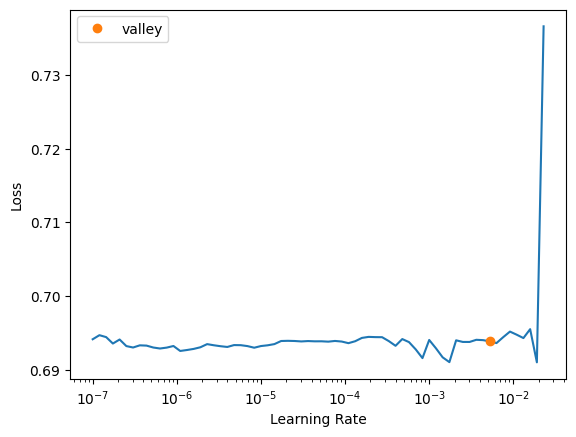

In [26]:
learn.lr_find()

In [28]:
learn.fit_one_cycle(10, 3.0199516913853586e-05)

epoch,train_loss,valid_loss,accuracy,time
0,0.693252,0.693158,0.500000,01:10


KeyboardInterrupt: 